In [1]:
import mxnet as mx
from mxnet import gluon,autograd,contrib,image,nd
from mxnet.gluon import data as gdata,loss as gloss,nn
import gluoncv
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import time

C:\Users\lenovo\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sys.path.insert(0,"../")
import gluonbook as gb

## Faster-RCNN

In [3]:
train_data = gluoncv.data.VOCDetection(root ='../data/VOCdevkit',splits=[(2007,'trainval')])

In [4]:
print('train_data',len(train_data))

train_data 5011


In [5]:
type(train_data)

gluoncv.data.pascal_voc.detection.VOCDetection

In [6]:
train_data.num_class

20

In [7]:
train_img,train_label = train_data[0]

In [8]:
print('img shape',train_img.shape)
print('img label',train_label.shape)

img shape (375, 500, 3)
img label (5, 6)


In [9]:
train_label

array([[262., 210., 323., 338.,   8.,   0.],
       [164., 263., 252., 371.,   8.,   0.],
       [  4., 243.,  66., 373.,   8.,   1.],
       [240., 193., 294., 298.,   8.,   0.],
       [276., 185., 311., 219.,   8.,   1.]])

In [10]:
bboxes = train_label[:, :4]
cids = train_label[:, 4:5]
print('bboxes:', bboxes.shape, 'class ids:', cids.shape)

bboxes: (5, 4) class ids: (5, 1)


In [11]:
from gluoncv.utils import viz

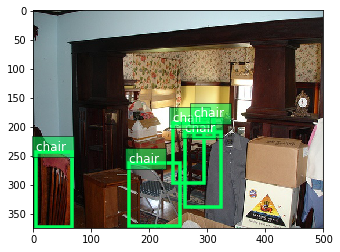

In [12]:
ax = viz.plot_bbox(train_img,bboxes,labels=cids,class_names=train_data.classes)
plt.show()

In [13]:
from gluoncv.data.transforms import presets
from gluoncv import utils

In [14]:
short, max_size = 600, 1000  # resize image to short side 600 px, but keep maximum length within 1000
train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size)

In [15]:
utils.random.seed(233)  # fix seed in this tutorial

In [16]:
train_image2, train_label2 = train_transform(train_img, train_label)
print('tensor shape:', train_image2.shape)
print('box and id shape:', train_label2.shape)

tensor shape: (3, 600, 800)
box and id shape: (5, 6)


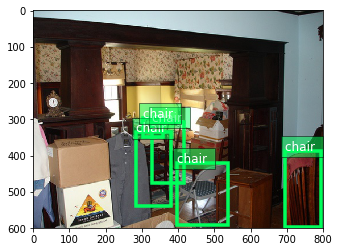

In [17]:
ax = viz.plot_bbox((train_image2.transpose((1,2,0))*nd.array((0.229, 0.224, 0.225)) + nd.array((0.485, 0.456, 0.406))).asnumpy()*255
                   ,train_label2[:,:4],labels=train_label2[:,4:5],class_names=train_data.classes)

创建Dataloader
使用batch_size = 1

In [18]:
from gluoncv.data.batchify import Tuple, Append
from mxnet.gluon.data import DataLoader

In [19]:
batch_size = 1

In [20]:
batchify_fn = Tuple(Append(), Append())

In [21]:
train_loader = DataLoader(train_data.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover')

In [22]:
for ib, batch in enumerate(train_loader):
    if ib > 3:
        break
    print('data 0:', batch[0][0].shape, 'label 0:', batch[1][0].shape)
#     print('data 1:', batch[0][1].shape, 'label 1:', batch[1][1].shape)

data 0: (1, 3, 552, 1000) label 0: (1, 35, 6)
data 0: (1, 3, 524, 1000) label 0: (1, 3, 6)
data 0: (1, 3, 600, 899) label 0: (1, 3, 6)
data 0: (1, 3, 600, 800) label 0: (1, 5, 6)


In [23]:
from gluoncv import model_zoo
net = model_zoo.get_model('faster_rcnn_resnet50_v1b_voc', pretrained_base=False)
print(net)

FasterRCNN(
  (features): HybridSequential(
    (0): Conv2D(None -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=None)
    (2): Activation(relu)
    (3): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False)
    (4): HybridSequential(
      (0): BottleneckV1b(
        (conv1): Conv2D(None -> 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=None)
        (relu1): Activation(relu)
        (conv2): Conv2D(None -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=True, in_channels=None)
        (relu2): Activation(relu)
        (conv3): Conv2D(None -> 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm(axis=

)


In [24]:
# the loss to penalize incorrect foreground/background prediction
rpn_cls_loss = mx.gluon.loss.SigmoidBinaryCrossEntropyLoss(from_sigmoid=False)
# the loss to penalize inaccurate anchor boxes
rpn_box_loss = mx.gluon.loss.HuberLoss(rho=1/9.)  # == smoothl1
# the loss to penalize incorrect classification prediction.
rcnn_cls_loss = mx.gluon.loss.SoftmaxCrossEntropyLoss()
# and finally the loss to penalize inaccurate proposals
rcnn_box_loss = mx.gluon.loss.HuberLoss()  # == smoothl1

In [26]:
net.initialize()
box_ids, scores, bboxes = net(batch[0][0])

In [32]:
box_ids[0][1000:1500,:]


[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.

In [26]:
x = mx.nd.zeros(shape=(1, 3, 600, 800))
net.initialize()
cids, scores, bboxes = net(x)

# RPN training targets

In [27]:
train_transform = presets.rcnn.FasterRCNNDefaultTrainTransform(short, max_size, net)
# Return images, labels, rpn_cls_targets, rpn_box_targets, rpn_box_masks loosely
batchify_fn = Tuple(*[Append() for _ in range(5)])
# For the next part, we only use batch size 1
batch_size = 1
train_loader = DataLoader(train_data.transform(train_transform), batch_size, shuffle=True,
                          batchify_fn=batchify_fn, last_batch='rollover')

In [28]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.train_mode():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # -1 marks ignored label
            print('rpn cls label:', rpn_cls_targets.shape)
            # mask out ignored box label
            print('rpn box label:', rpn_box_targets.shape)
            print('rpn box mask:', rpn_box_masks.shape)

data: (1, 3, 600, 800)
box: (1, 1, 4)
label: (1, 1, 1)
rpn cls label: (1, 28500)
rpn box label: (1, 28500, 4)
rpn box mask: (1, 28500, 4)


In [130]:
batch[0],batch[1]

([
  [[[[-1.0904187  -1.3301654  -1.5185376  ...  0.07406463  0.02269024
       0.02269024]
     [-1.3472902  -0.9876702  -0.5081771  ...  0.05693974  0.1939379
       0.2966864 ]
     [-1.5870366  -0.5081771   0.810429   ...  0.09118938  0.41655967
       0.5878072 ]
     ...
     [-0.55955136 -0.5424266  -0.5253019  ... -0.6622999  -0.6622999
      -0.6451751 ]
     [-0.49105233 -0.5081771  -0.55955136 ... -0.6622999  -0.67942464
      -0.67942464]
     [-0.43967807 -0.49105233 -0.59380084 ... -0.6622999  -0.67942464
      -0.69654936]]
  
    [[-0.757703   -0.9502801  -1.0728291  ...  0.3452382   0.2752102
       0.2577032 ]
     [-1.0728291  -0.65266097 -0.07492995 ...  0.2401962   0.3452382
       0.41526622]
     [-1.3879551  -0.23249297  1.1855743  ...  0.18767506  0.45028022
       0.57282925]
     ...
     [-0.16246496 -0.14495796 -0.12745096 ... -0.9852941  -0.9677871
      -0.9677871 ]
     [-0.09243695 -0.10994396 -0.16246496 ... -0.9852941  -0.9852941
      -0.9852941 ]
  

In [147]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.train_mode():
        data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks  = train_transform(batch[0][0][0].transpose((1,2,0)),batch[1][0][0,:,:5])

In [149]:
rpn_box_masks.shape

(28500, 4)

In [29]:
for rpn in rpn_box_targets[0]:
    if rpn[0]!=0:
        print(rpn)


[ 0.08884352  0.09112278 -0.17662352 -0.3018816 ]
<NDArray 4 @cpu(0)>

[ 0.08884352  0.04934732 -0.17662352 -0.3018816 ]
<NDArray 4 @cpu(0)>

[ 0.08884352  0.00757187 -0.17662352 -0.3018816 ]
<NDArray 4 @cpu(0)>

[ 0.08884352 -0.03420359 -0.17662352 -0.3018816 ]
<NDArray 4 @cpu(0)>

[ 0.08884352 -0.07597905 -0.17662352 -0.3018816 ]
<NDArray 4 @cpu(0)>

[ 0.08884352 -0.1177545  -0.17662352 -0.3018816 ]
<NDArray 4 @cpu(0)>


In [30]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.train_mode():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            # network forward
            cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(batch[0][0], gt_box)
            # generate targets for rcnn
            cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)

            print('data:', data.shape)
            # box and class labels
            print('box:', gt_box.shape)
            print('label:', gt_label.shape)
            # rcnn does not have ignored label
            print('rcnn cls label:', cls_targets.shape)
            # mask out ignored box label
            print('rcnn box label:', box_targets.shape)
            print('rcnn box mask:', box_masks.shape)

data: (1, 3, 600, 800)
box: (1, 1, 4)
label: (1, 1, 1)
rcnn cls label: (1, 128)
rcnn box label: (1, 128, 20, 4)
rcnn box mask: (1, 128, 20, 4)


In [31]:
for box in box_targets[0]:
    print(box)


[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0

<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[

<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[

<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[

<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
<NDArray 20x4 @cpu(0)>

[

In [32]:
for ib, batch in enumerate(train_loader):
    if ib > 0:
        break
    with autograd.record():
        for data, label, rpn_cls_targets, rpn_box_targets, rpn_box_masks in zip(*batch):
            gt_label = label[:, :, 4:5]
            gt_box = label[:, :, :4]
            # network forward
            cls_preds, box_preds, roi, samples, matches, rpn_score, rpn_box, anchors = net(data, gt_box)
            # generate targets for rcnn
            cls_targets, box_targets, box_masks = net.target_generator(roi, samples, matches, gt_label, gt_box)

            # losses of rpn
            rpn_score = rpn_score.squeeze(axis=-1)
            num_rpn_pos = (rpn_cls_targets >= 0).sum()
            rpn_loss1 = rpn_cls_loss(rpn_score, rpn_cls_targets, rpn_cls_targets >= 0) * rpn_cls_targets.size / num_rpn_pos
            rpn_loss2 = rpn_box_loss(rpn_box, rpn_box_targets, rpn_box_masks) * rpn_box.size / num_rpn_pos

            # losses of rcnn
            num_rcnn_pos = (cls_targets >= 0).sum()
            rcnn_loss1 = rcnn_cls_loss(cls_preds, cls_targets, cls_targets >= 0) * cls_targets.size / cls_targets.shape[0] / num_rcnn_pos
            rcnn_loss2 = rcnn_box_loss(box_preds, box_targets, box_masks) * box_preds.size / box_preds.shape[0] / num_rcnn_pos


In [120]:
rpn_box_masks.shape

(1, 28500, 4)

In [68]:
anchor_generator = net.rpn.anchor_generator

In [85]:
x = nd.random.uniform(shape=(1,3,10,10))

In [89]:
anchor_generator(x)


[[[ -15.   -4.   30.   19.]
  [ -38.  -16.   53.   31.]
  [ -84.  -40.   99.   55.]
  ...
  [ 108.   64.  195.  239.]
  [  64.  -24.  239.  327.]
  [ -24. -200.  327.  503.]]]
<NDArray 1x1500x4 @cpu(0)>

In [99]:
y= nd.random.uniform(shape=(10,))

In [115]:
argmax = nd.random.uniform(shape=(5,1)).squeeze(axis=-1)

In [116]:
nd.slice_like(y, argmax)


[0.29823545 0.64663315 0.8141332  0.84691167 0.73264706]
<NDArray 5 @cpu(0)>

In [121]:
z = nd.random.uniform(shape=(5,1))

In [125]:
z = z.expand_dims(axis=0)

In [128]:
z[0].shape

(5, 1)